pysindy is already installed.
--- Processing Video: /content/drive/MyDrive/Research with Dr. Acosta Minoli/Video/Video_Difusion_editado_.mp4 ---
Resolution: 1920x1080 | FPS: 29.97000029702676
Full dataset saved to: dye_data.csv

PART 2: Running Original Model (Degree=3, Threshold=0.001)
Discovered Equation:
(A)' = 0.012 1 + -0.073 A + 0.341 A^2 + -0.622 A^3


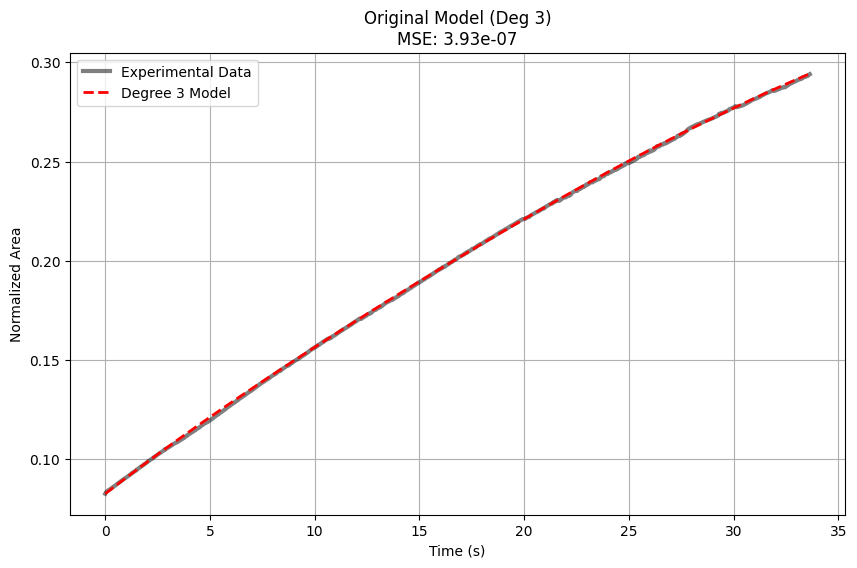


PART 3: Running Hyperparameter Sweep (Finding the Best Model)
Testing 30 combinations...


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.1) and eliminated all c

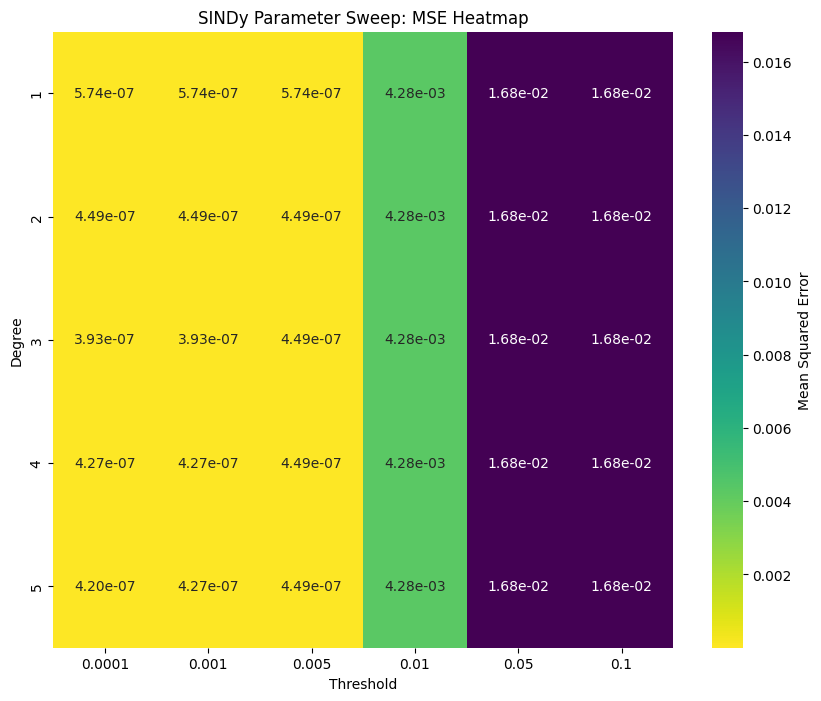


WINNER FOUND:
Degree: 3, Threshold: 0.0001
Lowest MSE: 3.93e-07
Best Equation:
(A)' = 0.012 1 + -0.073 A + 0.341 A^2 + -0.622 A^3


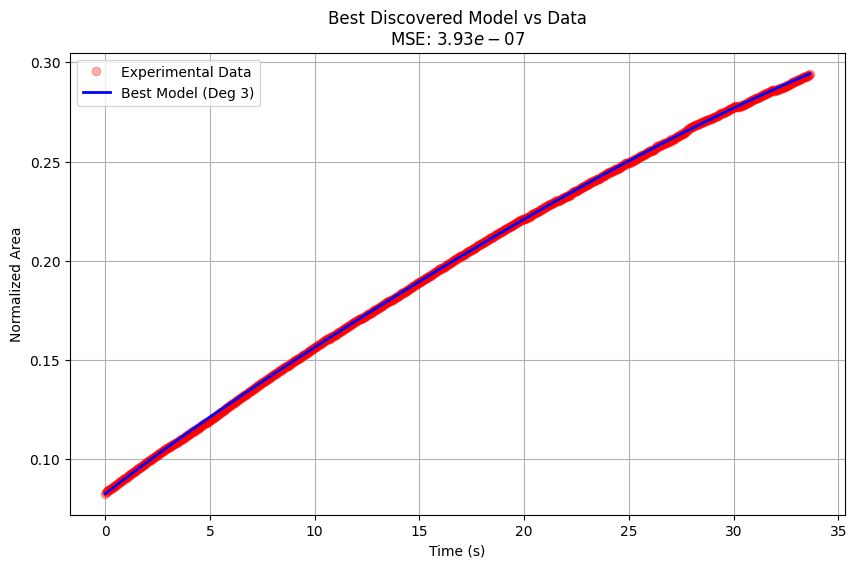

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import subprocess
try:
    import pysindy as ps
    print("pysindy is already installed.")
except ImportError:
    print("pysindy not found. Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pysindy"])
    import pysindy as ps
    print("pysindy installed and imported successfully.")

from scipy.integrate import solve_ivp
import seaborn as sns

def process_video_and_save_data(video_path, output_csv="dye_data.csv"):
    """
    Reads the video, extracts dye area, calculates normalized area,
    saves to CSV, and returns the data arrays for analysis.
    """
    print(f"--- Processing Video: {video_path} ---")

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video at {video_path}")
        return None, None

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    total_pixels = width * height

    print(f"Resolution: {width}x{height} | FPS: {fps}")

    data_points = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break


        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        _, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

        dye_pixels = cv2.countNonZero(mask)
        area_fraction = dye_pixels / total_pixels
        current_time = frame_idx / fps

        data_points.append({
            "Time_Seconds": current_time,
            "Normalized_Area": area_fraction,
            "Pixel_Count": dye_pixels
        })

        frame_idx += 1

    cap.release()

    df = pd.DataFrame(data_points)
    df.to_csv(output_csv, index=False)
    print(f"Full dataset saved to: {output_csv}")

    df['Second_Integer'] = df['Time_Seconds'].astype(int)
    df_seconds = df.groupby('Second_Integer').first().reset_index()
    df_seconds[['Time_Seconds', 'Normalized_Area']].to_csv("dye_data_per_second.csv", index=False)

    return df['Time_Seconds'].values, df['Normalized_Area'].values

video_filename = "/content/drive/MyDrive/Research with Dr. Acosta Minoli/Video/Video_Difusion_editado_.mp4"


times, areas = process_video_and_save_data(video_filename)

if times is None:
    print("Stopping execution due to video load error.")
    exit()

A = areas.reshape(-1, 1)

print("\n" + "="*40)
print("PART 2: Running Original Model (Degree=3, Threshold=0.001)")
print("="*40)


feature_library = ps.PolynomialLibrary(degree=3)
optimizer = ps.STLSQ(threshold=0.001)
model_orig = ps.SINDy(
    optimizer=optimizer,
    feature_library=feature_library,
    differentiation_method=ps.FiniteDifference()
)


model_orig.fit(A, t=times, feature_names=["A"])
print("Discovered Equation:")
model_orig.print()

def original_ode_model(t, y):
    return model_orig.predict(np.array([y]).reshape(1, -1))[0]


sol_orig = solve_ivp(original_ode_model, (times[0], times[-1]), [areas[0]], t_eval=times, method='RK45')


plt.figure(figsize=(10, 6))
plt.plot(times, areas, 'k-', alpha=0.5, linewidth=3, label='Experimental Data')
if sol_orig.success:
    plt.plot(sol_orig.t, sol_orig.y[0], 'r--', linewidth=2, label='Degree 3 Model')
    mse_orig = np.mean((areas - sol_orig.y[0])**2)
    plt.title(f'Original Model (Deg 3)\nMSE: {mse_orig:.2e}')
else:
    plt.title('Original Model (Deg 3) - Integration Failed')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Area')
plt.legend()
plt.grid(True)
plt.show()


print("\n" + "="*40)
print("PART 3: Running Hyperparameter Sweep (Finding the Best Model)")
print("="*40)

degrees = [1, 2, 3, 4, 5]
thresholds = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
results = []

print(f"Testing {len(degrees)*len(thresholds)} combinations...")

for deg in degrees:
    for thresh in thresholds:

        lib = ps.PolynomialLibrary(degree=deg)
        opt = ps.STLSQ(threshold=thresh)
        model = ps.SINDy(optimizer=opt, feature_library=lib, differentiation_method=ps.FiniteDifference())
        model.fit(A, t=times, feature_names=["A"])


        def temp_wrapper(t_val, x):
            return model.predict(np.array([x]).reshape(1, -1))[0]

        try:
            sol = solve_ivp(temp_wrapper, (times[0], times[-1]), [areas[0]], t_eval=times, method='RK45')

            if sol.success:
                mse = np.mean((areas - sol.y[0])**2)
                complexity = np.count_nonzero(model.coefficients())
            else:
                mse = np.inf
                complexity = 0
        except:
            mse = np.inf
            complexity = 0

        results.append({
            'Degree': deg,
            'Threshold': thresh,
            'MSE': mse,
            'Complexity': complexity
        })

res_df = pd.DataFrame(results)
plot_df = res_df[res_df['MSE'] != np.inf].copy()

if not plot_df.empty:
    pivot_table = plot_df.pivot(index='Degree', columns='Threshold', values='MSE')
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".2e", cmap="viridis_r", cbar_kws={'label': 'Mean Squared Error'})
    plt.title("SINDy Parameter Sweep: MSE Heatmap")
    plt.show()

    best_run = plot_df.loc[plot_df['MSE'].idxmin()]
    print(f"\nWINNER FOUND:")
    print(f"Degree: {int(best_run['Degree'])}, Threshold: {best_run['Threshold']}")
    print(f"Lowest MSE: {best_run['MSE']:.2e}")

    best_lib = ps.PolynomialLibrary(degree=int(best_run['Degree']))
    best_opt = ps.STLSQ(threshold=best_run['Threshold'])
    best_model = ps.SINDy(optimizer=best_opt, feature_library=best_lib, differentiation_method=ps.FiniteDifference())
    best_model.fit(A, t=times, feature_names=["A"])

    print("Best Equation:")
    best_model.print()

    def best_wrapper(t_val, x):
        return best_model.predict(np.array([x]).reshape(1, -1))[0]

    sol_best = solve_ivp(best_wrapper, (times[0], times[-1]), [areas[0]], t_eval=times, method='RK45')

    plt.figure(figsize=(10, 6))
    plt.plot(times, areas, 'ro', alpha=0.3, linewidth=4, label='Experimental Data')
    plt.plot(sol_best.t, sol_best.y[0], 'b-', linewidth=2, label=f'Best Model (Deg {int(best_run["Degree"])})')
    plt.title(rf'Best Discovered Model vs Data' + '\n' + rf'MSE: ${best_run["MSE"]:.2e}$')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Area')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("All models failed to integrate (unstable). Check data scaling.")


Validating with Train/Test Split (2/3 Train, 1/3 Test)
Training on first 22.16 seconds.
Forecasting (Testing) on remaining 11.44 seconds.

Equation discovered from Training Data:
(A)' = 0.026 1 + -0.361 A + 2.321 A^2 + -4.964 A^3

Training MSE: 4.82e-07
Testing MSE : 2.77e-04


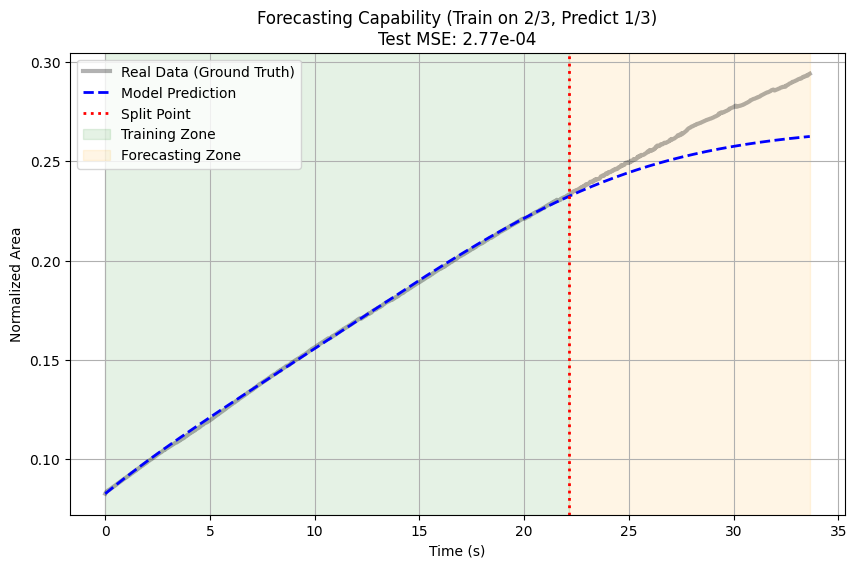

In [5]:
print("\n" + "="*40)
print("Validating with Train/Test Split (2/3 Train, 1/3 Test)")
print("="*40)

# 1. Split Data
split_idx = int(0.66 * len(times)) # 2/3 split point

t_train = times[:split_idx]
A_train = A[:split_idx]

t_test = times[split_idx:]
A_test = A[split_idx:]

print(f"Training on first {t_train[-1]:.2f} seconds.")
print(f"Forecasting (Testing) on remaining {t_test[-1] - t_test[0]:.2f} seconds.")


best_deg = int(best_run['Degree'])
best_thresh = best_run['Threshold']

lib_train = ps.PolynomialLibrary(degree=best_deg)
opt_train = ps.STLSQ(threshold=best_thresh)

model_train = ps.SINDy(
    optimizer=opt_train,
    feature_library=lib_train,
    differentiation_method=ps.FiniteDifference()
)

model_train.fit(A_train, t=t_train, feature_names=["A"])
print("\nEquation discovered from Training Data:")
model_train.print()

def forecast_wrapper(t_val, y):
    return model_train.predict(np.array([y]).reshape(1, -1))[0]

sol_forecast = solve_ivp(
    forecast_wrapper,
    (times[0], times[-1]),
    [A_train[0][0]],
    t_eval=times,
    method='RK45'
)

if sol_forecast.success:

    pred_full = sol_forecast.y[0]
    pred_train = pred_full[:split_idx]
    pred_test = pred_full[split_idx:]


    mse_train = np.mean((A_train.flatten() - pred_train)**2)
    mse_test = np.mean((A_test.flatten() - pred_test)**2)

    print(f"\nTraining MSE: {mse_train:.2e}")
    print(f"Testing MSE : {mse_test:.2e}")

    plt.figure(figsize=(10, 6))

    plt.plot(times, areas, 'k-', alpha=0.3, linewidth=3, label='Real Data (Ground Truth)')

    plt.plot(sol_forecast.t, sol_forecast.y[0], 'b--', linewidth=2, label='Model Prediction')


    plt.axvline(x=t_train[-1], color='r', linestyle=':', linewidth=2, label='Split Point')

    plt.axvspan(times[0], t_train[-1], alpha=0.1, color='green', label='Training Zone')
    plt.axvspan(t_train[-1], times[-1], alpha=0.1, color='orange', label='Forecasting Zone')

    plt.title(f"Forecasting Capability (Train on 2/3, Predict 1/3)\nTest MSE: {mse_test:.2e}")
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Area')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Forecasting simulation failed (unstable model).")

--- Processing Video: /content/drive/MyDrive/Research with Dr. Acosta Minoli/Video/Video_Difusion_editado_.mp4 ---
Data saved to: dye_data.csv

PART 2: Splitting Data (80% Train / 20% Test)
Total Frames: 1009
Training Frames: 807 (0.00s to 26.89s)
Testing Frames : 202 (26.93s to 33.63s)

PART 3: Hyperparameter Sweep on TRAINING DATA ONLY
Testing 30 combinations...


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.1) and eliminated all c


WINNER (Best Fit on Training Data):
Degree: 4, Threshold: 0.0001
Training MSE: 3.68e-07

Discovered Equation (from 80% data):
(A)' = 0.039 1 + -0.763 A + 6.754 A^2 + -25.967 A^3 + 36.120 A^4

PART 4: Forecasting the Future (Testing on remaining 20%)
Testing MSE (Unseen Data): 3.96e-05


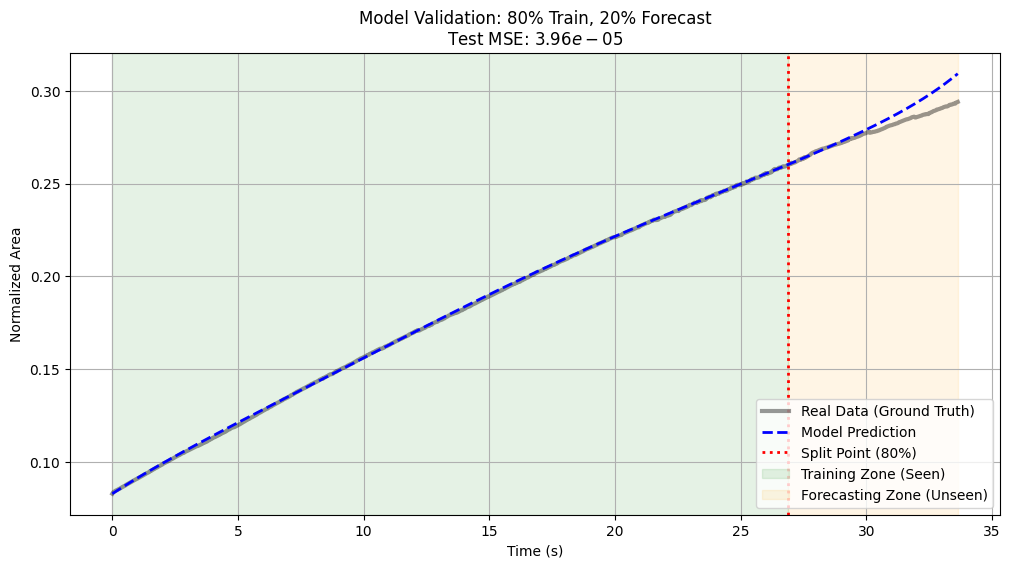

In [6]:
def process_video_and_save_data(video_path, output_csv="dye_data.csv"):
    print(f"--- Processing Video: {video_path} ---")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video at {video_path}")
        return None, None

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    total_pixels = width * height

    data_points = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret: break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

        dye_pixels = cv2.countNonZero(mask)
        area_fraction = dye_pixels / total_pixels
        current_time = frame_idx / fps

        data_points.append({"Time": current_time, "Area": area_fraction})
        frame_idx += 1

    cap.release()
    df = pd.DataFrame(data_points)
    df.to_csv(output_csv, index=False)
    print(f"Data saved to: {output_csv}")
    return df['Time'].values, df['Area'].values

video_filename = "/content/drive/MyDrive/Research with Dr. Acosta Minoli/Video/Video_Difusion_editado_.mp4"
times, areas = process_video_and_save_data(video_filename)

if times is None:
    print("Stopping execution due to video load error.")
    exit()

A = areas.reshape(-1, 1)

print("\n" + "="*40)
print("PART 2: Splitting Data (80% Train / 20% Test)")
print("="*40)

split_idx = int(0.80 * len(times))

t_train = times[:split_idx]
A_train = A[:split_idx]


t_test = times[split_idx:]
A_test = A[split_idx:]

print(f"Total Frames: {len(times)}")
print(f"Training Frames: {len(t_train)} (0.00s to {t_train[-1]:.2f}s)")
print(f"Testing Frames : {len(t_test)} ({t_test[0]:.2f}s to {t_test[-1]:.2f}s)")

print("\n" + "="*40)
print("PART 3: Hyperparameter Sweep on TRAINING DATA ONLY")
print("="*40)

degrees = [1, 2, 3, 4, 5]
thresholds = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
results = []

print(f"Testing {len(degrees)*len(thresholds)} combinations...")

for deg in degrees:
    for thresh in thresholds:

        lib = ps.PolynomialLibrary(degree=deg)
        opt = ps.STLSQ(threshold=thresh)
        model = ps.SINDy(optimizer=opt, feature_library=lib, differentiation_method=ps.FiniteDifference())
        model.fit(A_train, t=t_train)

        def temp_wrapper(t_val, x):
            return model.predict(np.array([x]).reshape(1, -1))[0]

        try:
            sol = solve_ivp(temp_wrapper, (t_train[0], t_train[-1]), [A_train[0][0]], t_eval=t_train, method='RK45')

            if sol.success:
                mse_train = np.mean((A_train.flatten() - sol.y[0])**2)
                complexity = np.count_nonzero(model.coefficients())
            else:
                mse_train = np.inf
                complexity = 0
        except:
            mse_train = np.inf
            complexity = 0

        results.append({
            'Degree': deg,
            'Threshold': thresh,
            'MSE_Train': mse_train,
            'Complexity': complexity
        })

res_df = pd.DataFrame(results)
valid_models = res_df[res_df['MSE_Train'] != np.inf].copy()

if not valid_models.empty:

    best_run = valid_models.loc[valid_models['MSE_Train'].idxmin()]

    print(f"\nWINNER (Best Fit on Training Data):")
    print(f"Degree: {int(best_run['Degree'])}, Threshold: {best_run['Threshold']}")
    print(f"Training MSE: {best_run['MSE_Train']:.2e}")

    best_lib = ps.PolynomialLibrary(degree=int(best_run['Degree']))
    best_opt = ps.STLSQ(threshold=best_run['Threshold'])
    best_model = ps.SINDy(optimizer=best_opt, feature_library=best_lib, differentiation_method=ps.FiniteDifference())
    best_model.fit(A_train, t=t_train, feature_names=["A"])

    print("\nDiscovered Equation (from 80% data):")
    best_model.print()

    print("\n" + "="*40)
    print("PART 4: Forecasting the Future (Testing on remaining 20%)")
    print("="*40)

    def forecast_wrapper(t_val, x):
        return best_model.predict(np.array([x]).reshape(1, -1))[0]

    sol_forecast = solve_ivp(
        forecast_wrapper,
        (times[0], times[-1]),
        [A_train[0][0]],
        t_eval=times,
        method='RK45'
    )

    if sol_forecast.success:
        pred_full = sol_forecast.y[0]

        pred_test = pred_full[split_idx:]

        mse_test = np.mean((A_test.flatten() - pred_test)**2)
        print(f"Testing MSE (Unseen Data): {mse_test:.2e}")

        plt.figure(figsize=(12, 6))

        plt.plot(times, areas, 'k-', alpha=0.4, linewidth=3, label='Real Data (Ground Truth)')

        plt.plot(sol_forecast.t, sol_forecast.y[0], 'b--', linewidth=2, label='Model Prediction')

        plt.axvline(x=t_train[-1], color='r', linestyle=':', linewidth=2, label='Split Point (80%)')
        plt.axvspan(times[0], t_train[-1], alpha=0.1, color='green', label='Training Zone (Seen)')
        plt.axvspan(t_train[-1], times[-1], alpha=0.1, color='orange', label='Forecasting Zone (Unseen)')

        plt.title(rf'Model Validation: 80% Train, 20% Forecast' + '\n' + rf'Test MSE: ${mse_test:.2e}$')
        plt.xlabel('Time (s)')
        plt.ylabel('Normalized Area')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    else:
        print("Forecasting simulation failed.")
else:
    print("No stable models found in the training sweep.")